# Tutorial 4 - 2ND Order SNN

## Learn about
- more advanced LIF Neuron models: Synaptic, Alpha

> Synaptic, Alpha 등, 보다 복잡한 LIF 모델에 대해 알아본다.

In [15]:
import snntorch as snn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from snntorch import spikeplot as splt
from snntorch import spikegen

In [16]:
#@title Plotting Settings

def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(syn_rec.detach().numpy())
  ax[1].set_ylim([0, 0.5])
  ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
  plt.xlabel("Time step")

  # Plot membrane potential
  ax[2].plot(mem_rec.detach().numpy())
  ax[2].set_ylim([0, 1.5])
  ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[3].set_yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem_rec.detach())
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  ax[2].set_yticks([])
  ax[2].set_ylabel("Output Spikes")

  plt.show()

# 1. Synaptic Conductance-based LIF Neuron model

## 1.1 Modeling Synaptic current

앞선 튜토리얼에서는 membrane potential, voltage 에 관련한 식들을 살펴보고, $\beta$ 를 정의했다. Synaptic model을 사용하기 위해서 이번에는, Synaptic current에 대해서도 살펴볼 것이다.

실제 뉴런이 전기 신호를 주고받을 때는 아래 그림과 같이 전류에 대해서도 exponetial 성분을 가지고 감쇠하는 전류 신호를 확인할 수 있다.

![26](./images/2_6_synaptic.png)

위와 같은 형태의 전류 신호는 이전 튜토리얼에서 봐왔던 membrane potential과 동일한 형태임을 알 수 있을 것이다. 그렇다면, 앞에서 $\beta$ 를 정의한것과 동일하게, synaptic current의 *decay rate* 를 $\alpha$ 로 하여 다음과 같이 정의한다.

> $\alpha =e^{-\frac{\Delta t}{\tau_{syn}}}$
>
> $\beta =e^{-\frac{\Delta t}{\tau_{mem}}}$

이산 시간에서 식을 처리하기 위해 $\Delta t=1$로 하고, synaptic current와 membrane potential의 식을 써보면 다음과 같다.

> $I_{syn}[t+1]=\underbrace{\alpha I_{syn}[t]}_{decay}+\underbrace{WX[t+1]}_{input}$
>
> $U[t+1]=\underbrace{\beta U[t]}_{decay}+\underbrace{I_{syn}[t+1]}_{Input}-\underbrace{R[t]}_{reset}$


## 1.2 Synaptic Neuron model in snnTorch

Synaptic conductance-based neuron model은 위에서 다룬 식에서 알 수 있듯이, passive membrane과 함께 current dynamics까지 고려해야 한다. snnTorch에서는 이와 같은 Synaptic 모델을 사용하는데 $\alpha, \beta$ 두 인자를 입력으로 받는다.

In [17]:
# Temporal dynamics
alpha = 0.9
beta  = 0.8
num_steps = 200

# Initialize 2nd-order LIF neuron
lif1 = snn.Synaptic(alpha=alpha, beta=beta)

# Periodic spiking input, spk_in = 0.2V
w = 0.2
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), dim=0)
spk_in     = spk_period.repeat(20)

# print(spk_period)
# print(spk_in)

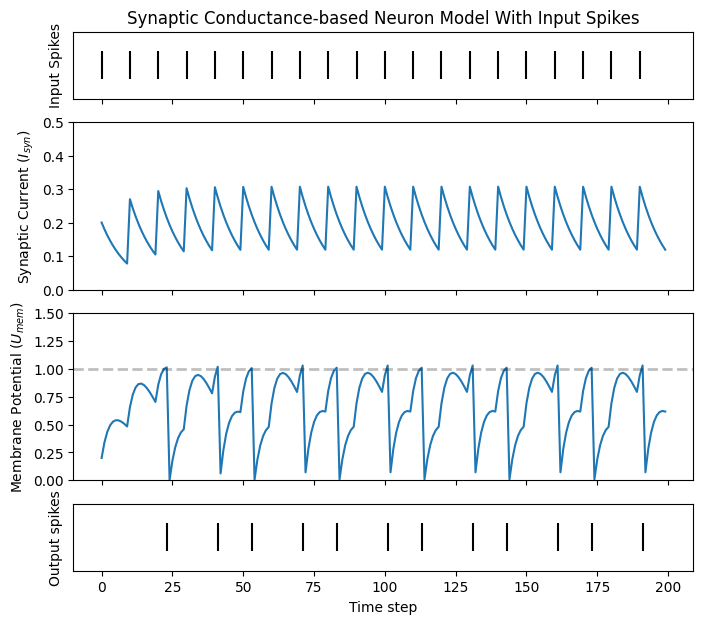

In [18]:
# Initialize hidden states and output
syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1)
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons
for step in range(num_steps):
    spk_out, syn, mem = lif1(spk_in[step], syn, mem)
    spk_rec.append(spk_out)
    syn_rec.append(syn)
    mem_rec.append(mem)
    
# Convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, 'Synaptic Conductance-based Neuron Model With Input Spikes')

Synaptic 모델의 입력과 출력을 나타내는 위 그래프는 아래 그림으로 더 쉽게 이해할 수 있을 것이다.

![27](./images/2_7_stein.png)



# 2. Alpha Neuron Model(Hacked Spike Response Model)

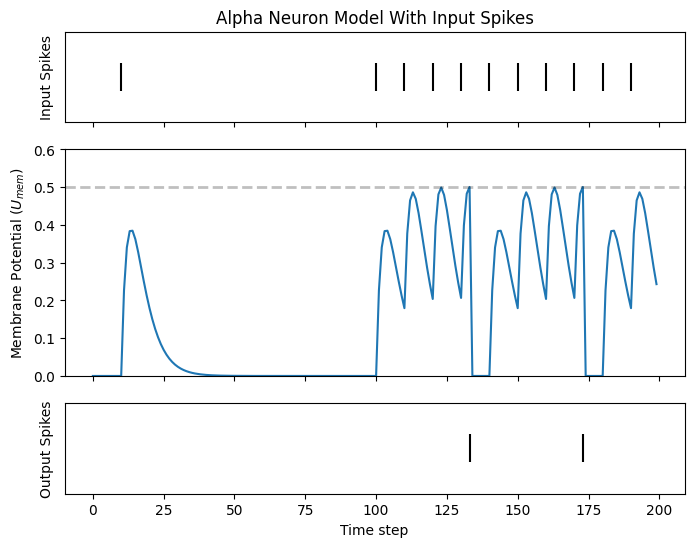

In [19]:
alpha = 0.8
beta = 0.7

# Initialize neuron
lif2 = snn.Alpha(alpha=alpha, beta=beta, threshold=0.5)

# Input spike: initial spike, and then period spiking
w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89),
                     (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * w).unsqueeze(1)

# Initialize parameters
syn_exc, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

# Run simulation
for step in range(num_steps):
  spk_out, syn_exc, syn_inh, mem = lif2(spk_in[step], syn_exc, syn_inh, mem)
  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

# Convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model With Input Spikes")